In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

%matplotlib inline

BATCH_SIZE = 10
TIME_STEPS = 20
DAYS = 200

from libs.utils import *

np.random.seed(0)

2024-11-26 16:24:19.844845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:24:19.850916: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:24:19.873703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732638259.909112  377472 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732638259.917770  377472 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 16:24:19.953380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
df_data = pd.read_csv('data/SP500.csv')
df_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...,...
4237,2016-11-03,2098.800049,2102.560059,2085.229980,2088.659912,2088.659912,3886740000
4238,2016-11-04,2083.790039,2099.070068,2083.790039,2085.179932,2085.179932,3837860000
4239,2016-11-07,2100.590088,2132.000000,2100.590088,2131.520020,2131.520020,3736060000
4240,2016-11-08,2129.919922,2146.870117,2123.560059,2139.560059,2139.560059,3916930000


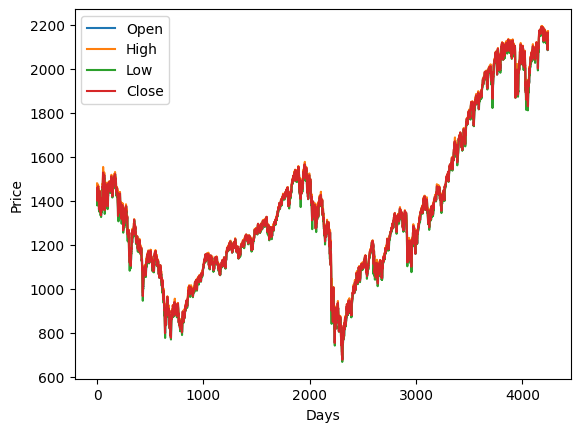

In [3]:
plt.plot(df_data['Open'])
plt.plot(df_data['High'])
plt.plot(df_data['Low'])
plt.plot(df_data['Close'])
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
plt.show()

In [4]:
df_data = df_data[['Open', 'High', 'Low', 'Close']]

min_max_scaler = MinMaxScaler()
df_data = min_max_scaler.fit_transform(df_data)
df_data = pd.DataFrame(df_data)

df_data.head()

,0,1,2,3
0,0.523669,0.522328,0.507608,0.514455
1,0.514368,0.507127,0.480681,0.477590
2,0.477379,0.479133,0.467688,0.479367
3,0.479162,0.478219,0.477174,0.480253
4,0.480050,0.497951,0.482852,0.505371


In [5]:
x_data, y_data = build_timeseries(df_data.values, 3, TIME_STEPS)

x_test = x_data[-DAYS:]
y_test = y_data[-DAYS:]

x_data = x_data[:-DAYS]
y_data = y_data[:-DAYS]

x_train, x_val, y_train, y_val = train_test_split(
	x_data,
	y_data,
	test_size=0.30,
	random_state = 42
)


length of time-series i/o (4222, 20, 4) (4222,)


In [6]:
x_train = trim_dataset(x_train, BATCH_SIZE)
x_val = trim_dataset(x_val, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)
y_val = trim_dataset(y_val, BATCH_SIZE)
x_test = trim_dataset(x_test, BATCH_SIZE)
y_test = trim_dataset(y_test, BATCH_SIZE)

In [7]:
lstm_model = Sequential()
lstm_model.add(LSTM(10, kernel_initializer='glorot_uniform'))
lstm_model.add(Dense(1, activation='relu', kernel_initializer = 'orthogonal'))
lstm_model.compile(loss='mean_squared_error', optimizer=Adam())

lstm_model.fit(
	x_train,
	y_train,
	epochs=50,
	batch_size=BATCH_SIZE,
	shuffle=True,
	validation_data=(x_val, y_val)
)

Epoch 1/50


2024-11-26 16:31:20.167620: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0055 - val_loss: 3.0959e-04
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.7251e-04 - val_loss: 3.0725e-04
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.5224e-04 - val_loss: 2.8115e-04
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.3066e-04 - val_loss: 2.2958e-04
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.4060e-04 - val_loss: 2.8209e-04
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.4056e-04 - val_loss: 2.1829e-04
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.2145e-04 - val_loss: 2.2538e-04
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.1008e-04 - val_loss: 2.1731e-04
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.0667e-04 - val_loss: 1.9781e-04
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.1036e-04 - val_loss: 2.1295e-04
Epoch 11/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.8

In [8]:
y_pred = lstm_model.predict(x_test, batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [9]:
y_pred_org = y_pred * min_max_scaler.data_range_[3] + min_max_scaler.data_min_[3]
y_test_org = y_test * min_max_scaler.data_range_[3] + min_max_scaler.data_min_[3]

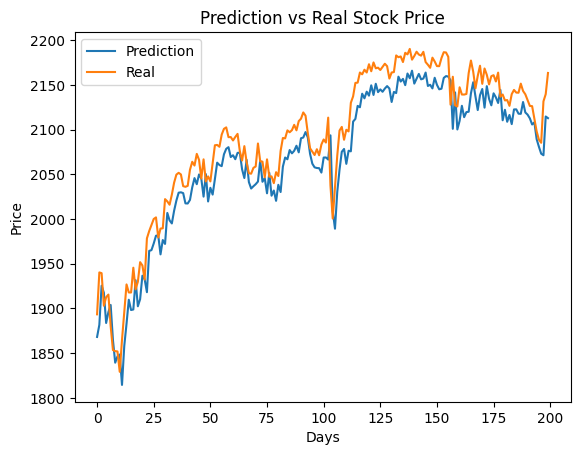

In [10]:
plt.plot(y_pred_org)
plt.plot(y_test_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [11]:
print('mae =', mean_absolute_error(y_test_org, y_pred_org))
print('mape =', mean_absolute_percentage_error(y_test_org, y_pred_org))

mae = 24.15254436418786
mape = 0.011566458562931103
